# Import Packages

In [1]:
# Standard Library Imports
import os
import sys
import json
import time
import requests
from tqdm import tqdm
import glob

## Data Manipulation and Analysis
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pylab import *

## Geospatial Operations
import geopandas as gpd
import rioxarray as rio
from leafmap import leafmap

## STAC and Stack Operations
import pystac_client
import stackstac

# Install pystac
* Using conda or mamba was taking a long time to install

In [ ]:
%pip install -U pystac

In [2]:
hdd_path = r"D:\Geospatial_Pessoal"
aoi_path = fr"{hdd_path}\STAC_py\pedrogao_grande_area_ardida_2017.geojson"

# Load the GeoJSON file
with open(aoi_path) as f:
    geojson_aoi = json.load(f)

# Extract all coordinates from the polygon

coordinates = geojson_aoi['features'][0]['geometry']['coordinates'][0]  # Assuming the first feature is the AOI

# Define the bounds from the GeoJSON for stacking

lon_min = min(coord[0] for coord in coordinates)
lat_min = min(coord[1] for coord in coordinates)
lon_max = max(coord[0] for coord in coordinates)
lat_max = max(coord[1] for coord in coordinates)

# Flatten the list of coordinates if you have a polygon (list of lists)
points = [(coord[1], coord[0]) for coord in coordinates]  # (lat, lon) tuples


In [3]:
start_date = "2017-01-01" 
end_date = "2017-07-31"
time_range = f"{start_date}/{end_date}"

# Search Sentinel 2 level 2 Images with cloud filtering 

In [4]:
sentinel_search_url = "https://earth-search.aws.element84.com/v1"
sentinel_stac_client = pystac_client.Client.open(sentinel_search_url)

items = sentinel_stac_client.search(
    intersects=geojson_aoi['features'][0]['geometry'],  # Use the geometry directly
    collections=["sentinel-2-l2a"],
    datetime=time_range,
    query={"eo:cloud_cover": {"lte": 10}}  # Filter by cloud coverage. lte = less than or equal to
).item_collection()

print("Number of items found:", len(items))

Number of items found: 19


In [14]:
sentinel_stack = stackstac.stack(items, assets=["red", "nir", "blue", "scl"],
                          gdal_env=stackstac.DEFAULT_GDAL_ENV.updated(
                               {'GDAL_HTTP_MAX_RETRY': 3,
                                'GDAL_HTTP_RETRY_DELAY': 5,
                               }),
                          epsg=4326, chunksize=(1, 1, 50, 50)).to_dataset(
       dim='band')

# This length number represents the number  of assets (bands) that are to be extracted
# len(sentinel_stack)

sentinel_stack

<xarray.Dataset> Size: 141GB
Dimensions:                                  (time: 19, y: 11060, x: 20981,
                                              band: 4)
Coordinates: (12/51)
  * time                                     (time) datetime64[ns] 152B 2017-...
    id                                       (time) <U24 2kB 'S2A_29TNE_20170...
  * x                                        (x) float64 168kB -10.18 ... -7.702
  * y                                        (y) float64 88kB 40.65 ... 39.65
    mgrs:utm_zone                            int64 8B 29
    s2:degraded_msi_data_percentage          int64 8B 0
    ...                                       ...
    gsd                                      (band) object 32B 10 10 10 None
    title                                    (band) <U30 480B 'Red (band 4) -...
    common_name                              (band) object 32B 'red' ... None
    center_wavelength                        (band) object 32B 0.665 ... None
    full_width_half_max                      (band) object 32B 0.038 ... None
    epsg                                     int64 8B 4326
Dimensions without coordinates: band
Data variables:
    red                                      (time, y, x) float64 35GB dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    nir                                      (time, y, x) float64 35GB dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    blue                                     (time, y, x) float64 35GB dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    scl                                      (time, y, x) float64 35GB dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
Attributes:
    spec:           RasterSpec(epsg=4326, bounds=(np.float64(-10.183261250575...
    crs:            epsg:4326
    transform:      | 0.00, 0.00,-10.18|\n| 0.00,-0.00, 40.65|\n| 0.00, 0.00,...
    resolution_xy:  (np.float64(0.00011828210482356383), np.float64(9.0088043...

# Download S2 dataset if required
* Sentinel 2 imagery is downloaded by asset, meaning as separate tiffs for red and nir bands

In [57]:
def download_asset(asset_url, local_path):
    try:
        response = requests.get(asset_url, stream=True)
        response.raise_for_status()  # Raises an error for bad responses
        
        # Get total file size for progress tracking
        total_size = int(response.headers.get('content-length', 0))
        
        # Create a tqdm progress bar
        with open(local_path, 'wb') as f:
            with tqdm(total=total_size, unit='B', unit_scale=True, desc=local_path, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [elapsed: {elapsed} | {rate_fmt}]') as bar:
                downloaded_size = 0
                start_time = time.time()  # Start time for speed calculation
                
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)
                    downloaded_size += len(chunk)
                    bar.update(len(chunk))
                    
                    # Calculate elapsed time and download speed
                    elapsed_time = time.time() - start_time
                    if elapsed_time > 0:
                        speed = downloaded_size / elapsed_time  # bytes per second
                        bar.set_postfix(speed=f"{speed / 1024:.2f} kB/s")  # Display speed in kB/s
        
        print(f"\nDownloaded: {local_path}")
    except requests.RequestException as e:
        print(f"Failed to download: {asset_url}, error: {str(e)}")
    except Exception as e:
        print(f"An error occurred while downloading {asset_url}: {str(e)}")

In [ ]:
output_directory = fr"{hdd_path}\STAC_py\output" 

assets_to_download = ["red", "nir", "blue", "scl"]  # Changed from B04 to red, B08 to nir

for item in items: 
    # Print the item ID and available assets for debugging
    print(f"Processing item: {item.id}")
    print("Available assets:", item.assets.keys())  # Print available asset names

    for asset_name in assets_to_download:
        if asset_name in item.assets:
            asset_url = item.assets[asset_name].href
            print(f"Downloading {asset_name} from {asset_url}")  # Print the URL being downloaded
            local_filename = os.path.join(output_directory, f"{item.id}_{asset_name}.tif")
            download_asset(asset_url, local_filename)
        else:
            print(f"Asset {asset_name} not found in item {item.id}")

print("All downloads completed.")

# Calculate NDVI

In [15]:
sentinel_stack['ndvi'] = xr.where(
    (sentinel_stack['nir'] + sentinel_stack['red']) != 0,
    (sentinel_stack['nir'] - sentinel_stack['red']) / (sentinel_stack['nir'] + sentinel_stack['red']),
    np.nan
)

# Remove attributes that are not time, y or x
sentinel_stack = sentinel_stack.drop_vars([c for c in sentinel_stack.coords if not (c in ['time', 'y', 'x'])])

# Calculate EVI

* evi = G * ((nir -r) / (nir + C1 * R - C2 * B +L)
* for sentinel 2: evi = 2.5 * ((nir - red)) / (nir + 6 * red - 7.5 * blue + 1)
* Source: https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/evi/

In [16]:
# evi = G * ((nir -r) / (nir + C1 * R - C2 * B +L)

# for sentinel 2
## evi = 2.5 * ((nir - red)) / (nir + 6 * red - 7.5 * blue + 1)
## https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/evi/


sentinel_stack['evi'] = xr.where(
    (sentinel_stack['nir'] + 6 * sentinel_stack['red'] - 7.5 * sentinel_stack['blue'] + 1) != 0, # Ensure denominator is not zero
    2.5 * (sentinel_stack['nir'] - sentinel_stack['red']) /
    (sentinel_stack['nir'] + 6 * sentinel_stack['red'] - 7.5 * sentinel_stack['blue'] + 1),
    np.nan  
)

# Remove attributes that are not time, y or x
sentinel_stack = sentinel_stack.drop_vars([c for c in sentinel_stack.coords if not (c in ['time', 'y', 'x', 'ndvi'])])

# Set Coordinate Reference System

In [19]:
aoi = gpd.read_file(fr"{hdd_path}/STAC_py/pedrogao_grande_area_ardida_2017.geojson")

crs = "EPSG:4326"
crs_number = crs[5:]
sentinel_stack = sentinel_stack.rio.write_crs(fr"{crs}", inplace=True)

# Batch export NDVI

In [ ]:
for i in range(sentinel_stack.sizes['time']):
    # Extract the timestamp and format it as YYYYMMDD
    time_str = str(sentinel_stack['time'].isel(time=i).dt.strftime('%Y%m%d').values)

    ndvi_slice = sentinel_stack['ndvi'].isel(time=i)
    ndvi_slice = ndvi_slice.fillna(-9999)
    ndvi_slice = ndvi_slice.rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=True)
    ndvi_clipped = ndvi_slice.rio.clip(aoi.geometry, aoi.crs, drop=True)
    ndvi_clipped.rio.write_nodata(-9999, inplace=True)

    output_path = f"{hdd_path}/STAC_py/ndvi_output/NDVI_{time_str}_{crs_number}.tiff"
    ndvi_clipped.rio.to_raster(output_path)

    print(f"Exported clipped NDVI time slice for {time_str} to {output_path}")

# Interpolate all band values for the first polygon vertex

In [20]:
first_point = points[0]
y, x = first_point
sentinel_point = sentinel_stack.interp(x=x, y=y, method="nearest")


# Check for x and y bounds for the first point

In [21]:
print(sentinel_stack.rio.crs)


# Check the bounds of the sentinel_stack
x_min, x_max = sentinel_stack.x.min().values, sentinel_stack.x.max().values
y_min, y_max = sentinel_stack.y.min().values, sentinel_stack.y.max().values

print(f"x bounds: {x_min} to {x_max}")
print(f"y bounds: {y_min} to {y_max}")

# Check if the point is within the bounds
if x_min <= x <= x_max and y_min <= y <= y_max:
    print("Point is within the bounds of the dataset.")
else:
    print("Point is outside the dataset bounds.")

EPSG:4326
x bounds: -10.18326125057508 to -7.7017026913767115
y bounds: 39.65459460114084 to 40.65087827334018
Point is within the bounds of the dataset.


# Lazy load the selected data subset and filter NDVI and EVI vegetation indexes

In [23]:
sentinel_point.load()

# Transform the xarray Dataset to a DataFrame
sentinel_table = sentinel_point.to_dataframe()

# Filter NDVI and EVI values that are out of the valid range (-1 to 1)
sentinel_table = sentinel_table[
    (sentinel_table['ndvi'] >= -1) & (sentinel_table['ndvi'] <= 1) &
    (sentinel_table['evi'] >= -1) & (sentinel_table['evi'] <= 1)
]
# Reset index if needed (optional)
sentinel_table.reset_index(inplace=True)

sentinel_table

,time,red,nir,blue,scl,ndvi,evi,spatial_ref,x,y
0,2017-01-05 11:27:37.242,0.0283,0.1746,0.0146,4.0,0.721045,0.296178,0,-8.925612,39.856864
1,2017-01-05 11:27:37.242,0.0244,0.1800,0.0043,4.0,0.761252,0.300583,0,-8.925612,39.856864
2,2017-01-08 11:37:54.889,0.0228,0.1778,0.0070,4.0,0.772682,0.307028,0,-8.925612,39.856864
3,2017-01-08 11:37:54.889,0.0241,0.1838,0.0073,4.0,0.768158,0.313469,0,-8.925612,39.856864
4,2017-01-15 11:24:12.457,0.0252,0.1854,0.0080,4.0,0.760684,0.313724,0,-8.925612,39.856864
5,2017-01-15 11:24:12.457,0.0250,0.1890,0.0049,4.0,0.766355,0.314840,0,-8.925612,39.856864
6,2017-01-18 11:36:59.635,0.0224,0.1810,0.0101,4.0,0.779744,0.319848,0,-8.925612,39.856864
7,2017-01-18 11:36:59.635,0.0223,0.1866,0.0079,4.0,0.786501,0.325695,0,-8.925612,39.856864
8,2017-01-25 11:23:33.458,0.0458,0.1916,0.0264,4.0,0.614153,0.287370,0,-8.925612,39.856864
9,2017-03-09 11:33:11.457,0.0285,0.1676,0.0128,4.0,0.709332,0.279857,0,-8.925612,39.856864


# NDVI plot

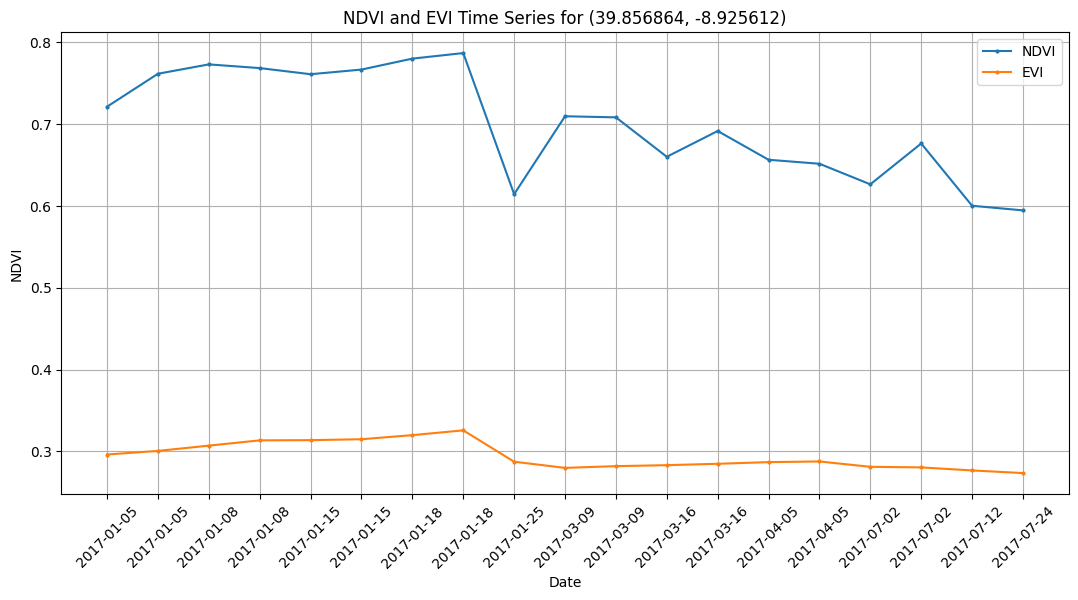

In [30]:
plt.figure(figsize=(13, 6))
sentinel_table['ndvi'].plot(label='NDVI', marker='o', linestyle='-', markersize=2) 
sentinel_table['evi'].plot(label='EVI', marker='o', linestyle='-', markersize=2)


plt.title(f"NDVI and EVI Time Series for ({y:.6f}, {x:.6f})")  # Display coordinates with 6 decimal places
plt.xlabel('Date')
plt.ylabel('NDVI')
plt.legend()
plt.grid()

# Format x-axis date labels using the 'time' column for the ticks

plt.xticks(ticks=range(len(sentinel_table)), labels=sentinel_table['time'].dt.strftime('%Y-%m-%d'), rotation=45)

plt.show()

# Webmap integration with leafmap
* Dinamically see the NDVI timeseries in the area of interest

In [83]:
m = leafmap.Map(basemap='Google Satellite')

ndvi_folder = r"D:\Geospatial_Pessoal\STAC_py\ndvi_output"
ndvi_images = glob.glob(os.path.join(ndvi_folder, "*.tiff"))

# Sort images by ascending timeframe
ndvi_images.sort()
ndvi_images

['D:\\Geospatial_Pessoal\\STAC_py\\ndvi_output\\NDVI_20170105_4326.tiff',
 'D:\\Geospatial_Pessoal\\STAC_py\\ndvi_output\\NDVI_20170108_4326.tiff',
 'D:\\Geospatial_Pessoal\\STAC_py\\ndvi_output\\NDVI_20170115_4326.tiff',
 'D:\\Geospatial_Pessoal\\STAC_py\\ndvi_output\\NDVI_20170118_4326.tiff',
 'D:\\Geospatial_Pessoal\\STAC_py\\ndvi_output\\NDVI_20170125_4326.tiff',
 'D:\\Geospatial_Pessoal\\STAC_py\\ndvi_output\\NDVI_20170309_4326.tiff',
 'D:\\Geospatial_Pessoal\\STAC_py\\ndvi_output\\NDVI_20170316_4326.tiff',
 'D:\\Geospatial_Pessoal\\STAC_py\\ndvi_output\\NDVI_20170405_4326.tiff',
 'D:\\Geospatial_Pessoal\\STAC_py\\ndvi_output\\NDVI_20170702_4326.tiff',
 'D:\\Geospatial_Pessoal\\STAC_py\\ndvi_output\\NDVI_20170712_4326.tiff',
 'D:\\Geospatial_Pessoal\\STAC_py\\ndvi_output\\NDVI_20170724_4326.tiff']

In [84]:
m.add_time_slider(
    ndvi_images,
    time_interval = 2,
    position="bottomright",
    band=[1], 
    zoom_to_layer=True,
    cmap="RdYlGn",  min=0, max=1)   

In [88]:
cmap_name = "RdYlGn"
num_colors = 5

# Create the colormap
cmap = plt.get_cmap(cmap_name)

# Sample colors from the colormap
colors = [cmap(i / (num_colors - 1)) for i in range(num_colors)]

# Convert colors to hexadecimal
colors = ['#{:02x}{:02x}{:02x}'.format(int(r * 255), int(g * 255), int(b * 255)) for r, g, b, _ in colors]

print(colors)

['#a50026', '#f88e52', '#fefebd', '#84ca66', '#006837']


In [89]:
labels = ["Very Low", "Low", "Moderate", "High", "Very High"]

m.add_legend(
    title="NDVI Values", 
    labels=labels, 
    colors=colors
    )

m


Map(center=[39.840581, -8.9358585], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title'…